# Auto-Encoding Variational Bayes
#### Kingma and Welling, 2013
Efficient inference and learning in a directed probabilistic models, in the presence of latent variables with an intractable posterior distribution over large datasets.

In [1]:
# Imports
%reload_ext autoreload
%autoreload 1

import os, sys
sys.path.append('../')
sys.path.append('../common')

from tools_general import tf, np
from IPython.display import Image
from tools_train import get_train_params, OneHot, vis_square
from tools_config import data_dir
from tools_train import get_train_params
import matplotlib.pyplot as plt
import imageio

In [2]:
# define parameters
networktype = 'VAE_MNIST'

work_dir = '../trained_models/%s/' %networktype

## Network definitions

In [3]:
# define networks
from tools_networks import deconv, conv, dense, clipped_crossentropy, dropout

def conch(A, B):
    '''Concatenate channelwise'''
    with tf.variable_scope("deconv"):
        X = tf.concat([A, B], axis=3)
        return X
    
def create_VAE_E(Xin, labels, is_training, Cout=1, trainable=True, reuse=False, networktype='vaeE'):
    '''input : batchsize * latend_dim and labels to make the generator conditional
        output: batchsize * 28 * 28 * 1'''
    with tf.variable_scope(networktype, reuse=reuse):
        # Xin = conch(Xin, labels)
        Eout = conv(Xin, is_training, kernel_w=4, stride=2, Cout=256, pad=1, trainable=trainable, act='reLu', norm='batchnorm', name='deconv1')  # 14*14
        Eout = conv(Eout, is_training, kernel_w=4, stride=2, Cout=512, pad=1, trainable=trainable, act='reLu', norm='batchnorm', name='deconv2')  # 7*7
        
        Xmu = dense(Eout, is_training, trainable=trainable, Cout=Cout, act=None, norm=None, name='dense_mean')
        Xsigma = dense(Eout, is_training, trainable=trainable, Cout=Cout, act=None, norm=None, name='dense_var')
    return Xmu, Xsigma
     
def create_VAE_D(z, labels, is_training, Cout=1, trainable=True, reuse=False, networktype='vaeD'):
    '''input : batchsize * latend_dim and labels to make the generator conditional
        output: batchsize * 28 * 28 * 1'''
    with tf.variable_scope(networktype, reuse=reuse):
        # #z = tf.concat(axis=-1, values=[z, labels])
        Gz = dense(z, is_training, Cout=4 * 4 * 256, act='reLu', norm='batchnorm', name='dense1')
        Gz = tf.reshape(Gz, shape=[-1, 4, 4, 256])  # 4
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=256, trainable=trainable, act='reLu', norm='batchnorm', name='deconv1')  # 11
        Gz = deconv(Gz, is_training, kernel_w=5, stride=2, Cout=128, trainable=trainable, act='reLu', norm='batchnorm', name='deconv2')  # 25
        Gz = deconv(Gz, is_training, kernel_w=4, stride=Cout, Cout=1, act=None, norm=None, name='deconv3')  # 28
        Gz = tf.nn.sigmoid(Gz)
    return Gz

def create_vae_trainer(base_lr=1e-4, networktype='VAE', latendDim=100):
    '''Train a Variational AutoEncoder'''
    eps = 1e-5
    
    is_training = tf.placeholder(tf.bool, [], 'is_training')

    inZ = tf.placeholder(tf.float32, [None, latendDim])
    inL = tf.placeholder(tf.float32, [None, 10])
    inX = tf.placeholder(tf.float32, [None, 28, 28, 1])

    Xmu, Xsigma = create_VAE_E(inX, inL, is_training, Cout=latendDim, trainable=True, reuse=False, networktype=networktype + '_vaeE') 
    
    Z = Xsigma * inZ + Xmu
    Xrec = create_VAE_D(Z, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_vaeD')
    
    # E[log P(X|z)]
    reconstruction_loss = tf.reduce_sum((inX -1.0) * tf.log(1.0 - Xrec + eps) - inX * tf.log(Xrec + eps), reduction_indices = [1,2,3])
    # D_KL(Q(z|X) || P(z|X))
    KL_QZ = 0.5 * tf.reduce_sum( tf.exp(Xsigma) + tf.square(Xmu) - 1 - Xsigma, reduction_indices = 1) 
    
    total_loss = tf.reduce_mean( reconstruction_loss + KL_QZ)  
    
    vaetrain = tf.train.AdamOptimizer(learning_rate=base_lr, beta1=0.9).minimize(total_loss)

    return vaetrain, total_loss, is_training, inZ, inX, inL, Xrec, Xmu

# Training VAE
You can either get the trained models from [my google drive](https://goo.gl/7PrKD2) or train your own models using the VAE.py script

## Evolution of approximate posterior Q(z|X) and likelihood P(X|z) during training with 2D latent space

Here we will keep the latent dimension to only 2 due to visualization matters but basicaly there is an optimum dimensionality in in the latent space which is bigger than 2.

In [4]:
batch_size = 128
base_lr = 1e-5
epochs = 30
latendDim = 2
spl = 200 #sample_per_label

data, max_iter, test_iter, test_int, disp_int = get_train_params(data_dir + '/' + networktype, batch_size, epochs=epochs,one_hot=False, test_in_each_epoch=1, networktype=networktype)
all_test_set, all_labels = data.test.next_batch(data.test.num_examples)

Xtest = np.zeros([spl*10, 28,28,1])
Xlabel = np.zeros([spl*10, 1])
for num in range(10):
    Xtest[spl*num:spl*num+spl,:] = all_test_set[np.where(all_labels==num)[0]][0:spl]
    Xlabel[spl*num:spl*num+spl,:] = num
Xlabel_onehot = OneHot(Xlabel.astype(np.int32))

Z_test = np.random.normal(size=[spl*10, latendDim], loc=0.0, scale=1.).astype(np.float32)

num_colors = ['C0.','C1.','C2.','C3.','C4.','C5.','C6.','C7.','C8.','C9.']

Extracting ../data//VAE_MNIST\train-images-idx3-ubyte.gz
Extracting ../data//VAE_MNIST\train-labels-idx1-ubyte.gz
Extracting ../data//VAE_MNIST\t10k-images-idx3-ubyte.gz
Extracting ../data//VAE_MNIST\t10k-labels-idx1-ubyte.gz
Trainset size: 55000 Testset_size: 10000


In [ ]:
tf.reset_default_graph() 
with tf.Session() as sess:
    vaetrain, total_loss, is_training, inZ, inX, inL, Xrec, Qmu = create_vae_trainer(base_lr, networktype=networktype, latendDim=latendDim)
    tf.global_variables_initializer().run()

    test_int = 20
    best_test_loss = np.inf 

    images = []

    for it in range(max_iter): 
        Z = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)

        if it == 2 or it % test_int == 0:
            accumulated_loss = 0.0 
            for i_test in range(test_iter):
                X, labels = data.test.next_batch(batch_size)
                recloss = sess.run(total_loss, feed_dict={inX:X, inL:np.zeros([batch_size,10]), inZ: Z, is_training:False})
                accumulated_loss = np.add(accumulated_loss, recloss)

            cur_test_loss = np.divide(accumulated_loss, test_iter)
            if cur_test_loss < best_test_loss:
                best_test_loss = cur_test_loss
                [Qmu_cur,Xrec_cur] = sess.run([Qmu,Xrec], feed_dict={inX:Xtest, inL:Xlabel_onehot, inZ: Z_test, is_training:False})
                fname = work_dir+ 'Iter_%d.jpg'%it
                fig = plt.figure(figsize=(10,5))
                fig.suptitle('Iter. #%d, Test_loss = %1.5f'%(it,best_test_loss))
                likelihood = np.zeros([100, 28, 28, 1])
                for num in range(10):
                    ax1 = fig.add_subplot(121)
                    ax1.plot(Qmu_cur[np.where(Xlabel==num)[0],0],Qmu_cur[np.where(Xlabel==num)[0],1],num_colors[num], label='%d'%num)
                    likelihood[np.arange(0,100,10)+num] = Xrec_cur[np.where(Xlabel==num)[0][:10]]
                    #print(np.arange(0,100,10)+num)
                ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05), ncol=1, fancybox=True, shadow=True)
                ax1.set_xlabel('Latent Dimension #1');ax1.set_ylabel('Latent Dimension #2')
                ax1.set_ylim([-7,7]);ax1.set_xlim([-7,7])

                ax2 = fig.add_subplot(122)
                ax2.imshow(vis_square(likelihood, [10, 10]), cmap='gray')
                ax2.set_xticks([])
                ax2.set_yticks([])

                plt.savefig(fname, dpi=300)
                plt.close()
                images.append(imageio.imread(fname))


        if it % (disp_int*100) == 0:print('-- It. %0.4d Best Results yet.[loss = %2.5f] saving results...' % (it,best_test_loss))

        X, labels = data.train.next_batch(batch_size)
        recloss, _ = sess.run([total_loss, vaetrain], feed_dict={inX:X, inL:np.zeros([batch_size,10]), inZ: Z, is_training:True})

    imageio.mimsave(work_dir+'posterior_likelihood_evolution.gif', images)

In [7]:
display(Image(url=work_dir+'posterior_likelihood_evolution.gif'))

Visulization of a Convolutional Variational Auto-Encoder with 2D latent space Z during training on MNIST dataset (handwritten digits). The Image to the right is the mean of the approximate posterior Q(z|X) and each color represents a class of digits within the dataset. Image to the left shows samples from the likelihood P(X|z) as a way to visualize the predictive prior. The title above shows the iteration number and total loss of the model at the point that images below were produced from the model under training. What we observe is the by the time the generated outputs (left image) get better, the points in the posterior also get into better seperated clusters.

# Experiments
Create demo networks and restore weights

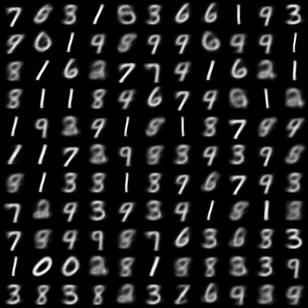

In [8]:
best_iter = 14586 # least cost
best_img = work_dir + 'Iter_%d.jpg' %best_iter
best_model = work_dir + "%.3d_model.ckpt" % best_iter
Image(filename=best_img)

In [10]:
latendDim = 2 # of the best model trained
batch_size = 128

tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

inZ = tf.placeholder(tf.float32, [None, latendDim])
inL = tf.placeholder(tf.float32, [None, 10])

Xrec = create_VAE_D(inZ, inL, is_training, trainable=True, reuse=False, networktype=networktype + '_vaeD')

tf.global_variables_initializer().run()

var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_vaeD')
saver = tf.train.Saver(var_list=var_list)
saver.restore(demo_sess, best_model)

INFO:tensorflow:Restoring parameters from ../trained_models/VAE_MNIST/14586_model.ckpt


### Generate new data

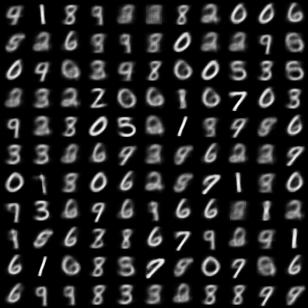

In [17]:
Z_test = np.random.normal(size=[batch_size, latendDim], loc=0.0, scale=1.).astype(np.float32)
labels_test = OneHot(np.random.randint(10, size=[batch_size]), n=10)    

vaeD_sample = demo_sess.run(Xrec, feed_dict={inL:labels_test, inZ: Z_test , is_training:False})
vis_square(vaeD_sample[:121], [11, 11], save_path=work_dir + 'sample.jpg')
Image(filename=work_dir + 'sample.jpg')

notice that our current model is not conditioned and basically we cannot generate exactly from whatever classes we want. That will be fixed in the Conditioned Variational Auto Encoders [Semi-Supervised Learning with Deep Generative Models](https://arxiv.org/abs/1406.5298).